# SpaCy + TextBlob Sentiment Baseline

This notebook tests a rule-based sentiment classifier using [`spacytextblob`](https://github.com/Veritas-AI/spacytextblob).  
We convert sentiment polarity into discrete labels: **positive**, **neutral**, **negative**.

While not state-of-the-art, this baseline is:

-   Fast
-   Useful as a basline in comparison with ML models


In [ ]:
import sys

sys.path.append("../scripts")

import pandas as pd
import spacy
from metrics import per_source_metrics
from plot_utils import plot_confusion_matrix
from sklearn.metrics import classification_report
from spacytextblob.spacytextblob import SpacyTextBlob

## Load Preprocessed Validation Data

We’ll use the same `val.csv` created during the preprocessing phase.


In [ ]:
val_df = pd.read_csv("../data/processed/val.csv")

print("Total validation examples:", len(val_df))
print("Sources:", val_df["source"].unique(), "\n")
print("Label breakdown:\n", val_df["label"].value_counts())

Total validation examples: 1788
Sources: ['FPB' 'Twitter' 'FiQA'] 

Label breakdown:
 label
neutral     1070
positive     444
negative     274
Name: count, dtype: int64


## Load SpaCy with TextBlob Pipeline


In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

## Rule: Polarity to Label

We convert continuous polarity to discrete classes:

-   \> 0.1 → **positive**
-   < -0.1 → **negative**
-   Otherwise → **neutral**


In [ ]:
def polarity_to_label(polarity):
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

## Run Inference

This is a lightweight rule-based process, so no training required.


In [ ]:
preds = []
for sentence in val_df["sentence"]:
    doc = nlp(str(sentence))
    polarity = doc._.blob.polarity
    preds.append(polarity_to_label(polarity))

## Evaluation


In [ ]:
y_true = val_df["label"]
y_pred = preds

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

    negative       0.38      0.23      0.29       274
     neutral       0.62      0.69      0.65      1070
    positive       0.32      0.32      0.32       444

    accuracy                           0.52      1788
   macro avg       0.44      0.41      0.42      1788
weighted avg       0.51      0.52      0.51      1788



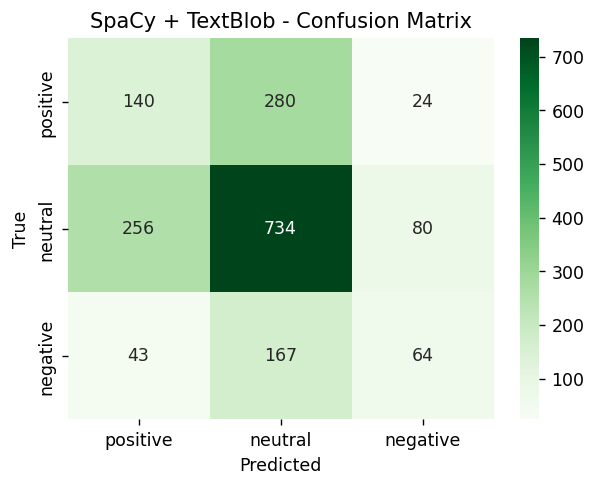

In [ ]:
plot_confusion_matrix(
    y_true,
    y_pred,
    labels=["positive", "neutral", "negative"],
    title="SpaCy + TextBlob - Confusion Matrix",
    cmap="Greens",
)

In [ ]:
spacy_results = per_source_metrics(y_true, y_pred, val_df["source"])
print("SpaCy+TextBlob Per-Source Performance:\n")
for source, acc, f1 in spacy_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

SpaCy+TextBlob Per-Source Performance:

FPB: Accuracy=0.562, Macro-F1=0.455
Twitter: Accuracy=0.530, Macro-F1=0.408
FiQA: Accuracy=0.306, Macro-F1=0.279


## Save Predictions

We'll save the predictions and metrics for later comparison.


In [ ]:
pd.DataFrame(
    classification_report(y_true, y_pred, output_dict=True)
).transpose().to_csv("../models/spacy/spacytextblob-preds.csv")

with open("../models/spacy/spacytextblob-preds.txt", "w") as f:
    for item in preds:
        f.write(item + "\n")

## Summary

This rule-based method is fast but limited by:

-   No domain knowledge
-   Difficulty detecting sarcasm, subtle cues, or context

Still, it's a useful **baseline** to compare against ML and LLM-based methods.

Next: Let’s evaluate **Azure OpenAI o4-mini** in **[5_o4mini_inference.ipynb](5_o4mini_inference.ipynb)**.
